# MovieLens-RAG-Recommendation-System (NLP + FAISS + LLM)

In [76]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string

from wordcloud import WordCloud
import seaborn as sns
import faiss

In [ ]:
# Reading files
ratings=pd.read_csv('Movie Recommendation/ratings.csv')
movies=pd.read_csv("Movie Recommendation/movies.csv")
tags=pd.read_csv("Movie Recommendation/tags.csv")
scores=pd.read_csv("Movie Recommendation/genome-scores.csv")
g_tages=pd.read_csv("Movie Recommendation/genome-tags.csv")

In [3]:
movies.shape

(86537, 3)

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [7]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [8]:
g_tages.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [ ]:
movie_ratings=movies.merge(ratings,on="movieId") # merging dataframes
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [10]:
tags

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
...,...,...,...,...
2328310,330923,176599,politically correct,1507547491
2328311,330933,3317,coming of age,1351279384
2328312,330933,3317,sexuality,1351279389
2328313,330947,5782,Not Luc Besson,1154110902


In [11]:
tags.drop("timestamp",axis="columns",inplace=True)
tags["tag"]=tags["tag"].astype(str)
tags

,userId,movieId,tag
0,10,260,good vs evil
1,10,260,Harrison Ford
2,10,260,sci-fi
3,14,1221,Al Pacino
4,14,1221,mafia
...,...,...,...
2328310,330923,176599,politically correct
2328311,330933,3317,coming of age
2328312,330933,3317,sexuality
2328313,330947,5782,Not Luc Besson


In [12]:
tags[tags["movieId"]==1]['tag'].values

array(['animation', 'friendship', 'toys', ..., 'Pixar animation',
       'Tom Hanks', 'é˜®ä¸€é¸£'], dtype=object)

In [ ]:
movie_tags = (                                          # extracting tags
    tags.groupby("movieId")["tag"]
        .apply(lambda x: " ".join(sorted(set(x))))
        .reset_index()
        .rename(columns={"tag": "tags"})
)
movie_tags

,movieId,tags
0,1,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,2,1860s 1960s 1990s 19th century 20th century 4k...
2,3,Ann Margaret Burgess Meredith CLV Daryl Hannah...
3,4,CLV based on novel or book characters chick fl...
4,5,4th wall CLV Comedy Diane Keaton Fantasy Steve...
...,...,...
53447,288765,apocalypse bad science plot holes post-apocaly...
53448,288779,Don Camillo Series
53449,288849,addiction animation short film
53450,288937,anime


In [14]:
movie_tags["tags"][0]

"1990s 2009 reissue in Stereoscopic 3-D 3 dimensional 3D 3d 55 movies every kid should see--Entertainment Weekly American Animation Animation Animation  BD-Video Best of Rotten Tomatoes: All Time Buzz Lightyear CG animation CGI CGI classic CLV Cartoon Comedy  DARING RESCUES DVD-Video Disney Disney animated feature Engaging Family cartoon HEROIC MISSION John Lasseter National Film Registry Os dois viram Oscar (Best Picture) Oscar (Special Achievement) Owned Pixar Pixar animation TOYS COME TO LIFE Tim Allen Tom Hanks Toy Story Tumey's To See Again Tumey's VHS TÃ©a Leoni does not star in this movie UNLIKELY FRIENDSHIPS USA Want Watched Woody accepting reality action action figure action figures ad for toys adventure affection alien almost favorite animated animated dog animated fictional tv commercial animation animmation antenna anthropomorphic toy anthropomorphism apology arcade arcade game arm asking directions astronaut audio flashback avi baby baby monitor backfire backyard bad guy b

In [15]:
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [16]:
df=movie_ratings.merge(movie_tags,on=["movieId"])
df

,movieId,title,genres,userId,rating,timestamp,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
...,...,...,...,...,...,...,...
33688651,288765,Bird Box Barcelona (2023),Horror|Thriller,236712,2.0,1689462634,apocalypse bad science plot holes post-apocaly...
33688652,288765,Bird Box Barcelona (2023),Horror|Thriller,243444,0.5,1689494308,apocalypse bad science plot holes post-apocaly...
33688653,288765,Bird Box Barcelona (2023),Horror|Thriller,276269,1.0,1689152119,apocalypse bad science plot holes post-apocaly...
33688654,288849,Colaholic (2018),(no genres listed),95007,3.0,1689268843,addiction animation short film


In [17]:
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'tags'], dtype='object')

In [ ]:
df=df.groupby(['movieId', 'title', 'genres', 'tags'])['rating'].mean().to_frame().reset_index() # Aggregating ratings by average
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...,3.893508
1,2,Jumanji (1995),Adventure|Children|Fantasy,1860s 1960s 1990s 19th century 20th century 4k...,3.278179
2,3,Grumpier Old Men (1995),Comedy|Romance,Ann Margaret Burgess Meredith CLV Daryl Hannah...,3.171271
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,CLV based on novel or book characters chick fl...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,4th wall CLV Comedy Diane Keaton Fantasy Steve...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama|Sci-Fi,Nazis World War II black and white interesting...,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror|Thriller,deep web horror thriller,1.714286
50151,288765,Bird Box Barcelona (2023),Horror|Thriller,apocalypse bad science plot holes post-apocaly...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000


In [ ]:
def duplicate_filter(text): # function to remove duplicated tags
    text=list(set(text.split()))
    return " ".join(text)

In [20]:
df["tags"]=df["tags"].apply(duplicate_filter)
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,classic emotional hat flying laughter boost ch...,3.893508
1,2,Jumanji (1995),Adventure|Children|Fantasy,classic store overalls fictional trapped relat...,3.278179
2,3,Grumpier Old Men (1995),Comedy|Romance,duringcreditsstinger sequel engraÃ§ada friend ...,3.171271
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick girl movie single novel based relationsh...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,was regret sequel more martin pregnancy Martin...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama|Sci-Fi,concept white II and black interesting Nazis s...,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror|Thriller,horror thriller web deep,1.714286
50151,288765,Bird Box Barcelona (2023),Horror|Thriller,tw apocalypse survival holes suicide post-apoc...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction animation film short,3.000000


In [21]:
df["tags"][0]

"classic emotional hat flying laughter boost child's fictional teamwork relationship poster antoinette skateboard sketch rescue Tom star touching crane unlikely DVDs lipstick rod Story binoculars rain buy urban mother controlled lifting villain during credits this box travel 3D dog braces surgical Cartoon played friend BD-Video party camera rivalry crash hurts debut land animal dimensional catchphrase flats through next ohio ventilation recliner All lovable original out score sliding Watched talking Registry a hearted toys yelling rival dinosaur buddy hero directions flashback guy feel-good bedroom reconnaissance from To shark to mixed arts gift biohazard operation Leoni ramp (Best é˜®ä¸€é¸£ boy confrontation thunderstorm Achievement) walkie asking see funny time 55 ya card jealousy figures COME ending disney package very shot CGI suburb frustration warm corkboard martial banister famous shaft Engaging friendship Oscar before scream depression erlend's robot claw fight RESCUES acting p

In [23]:
my_stopwords=set(stopwords.words("english"))
lem=WordNetLemmatizer()

In [ ]:
punc=string.punctuation
punc=list(punc)
punc

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [25]:
genres=df["genres"].str.replace("|"," ").values
genres

array(['Adventure Animation Children Comedy Fantasy',
       'Adventure Children Fantasy', 'Comedy Romance', ...,
       'Horror Thriller', '(no genres listed)', 'Drama'], dtype=object)

In [26]:
g=set()
for x in genres:
    if x!='(no genres listed)':
        g.update(x.split())
g

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [27]:
for x in g:
    my_stopwords.add(x.lower())

In [28]:
my_stopwords.update(["sci","fi","film","noir"])

In [ ]:
def get_pos(word):
                                            #Map POS tag to WordNet POS for lemmatization
    tag = pos_tag([word])[0][1][0].upper()  # get first char of POS tag
    if tag == "J":
        return wordnet.ADJ
    elif tag == "V":
        return wordnet.VERB
    elif tag == "N":
        return wordnet.NOUN
    elif tag == "R":
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# Pre-processing text data
def preprocessing(text):
    text=word_tokenize(text.lower())
    text=[word for word in text if word not in punc]
    text=[word for word in text if word.isalpha()]
    text=[lem.lemmatize(word,get_pos(word)) for word in text if word not in my_stopwords]
    return " ".join(text)

In [31]:
df["tags"]=df["tags"].apply(preprocessing)
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,classic emotional hat fly laughter boost child...,3.893508
1,2,Jumanji (1995),Adventure|Children|Fantasy,classic store overall fictional trap relations...,3.278179
2,3,Grumpier Old Men (1995),Comedy|Romance,duringcreditsstinger sequel friend fishing lem...,3.171271
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick girl movie single novel base relationshi...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama|Sci-Fi,concept white ii black interest nazi world,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror|Thriller,web deep,1.714286
50151,288765,Bird Box Barcelona (2023),Horror|Thriller,tw apocalypse survival hole suicide bad plot s...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction short,3.000000


In [32]:
df["genres"].value_counts()

genres
Drama                                              7467
Comedy                                             4251
Documentary                                        4061
(no genres listed)                                 2251
Comedy|Drama                                       1956
                                                   ... 
Adventure|Documentary|Drama|War                       1
Action|Adventure|Drama|Romance|Thriller|Western       1
Comedy|Horror|IMAX                                    1
Action|Comedy|Sci-Fi|IMAX                             1
Animation|Children|Comedy|Fantasy|Romance             1
Name: count, Length: 1599, dtype: int64

In [33]:
df["genres"]=df["genres"].str.replace("|"," ")
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,classic emotional hat fly laughter boost child...,3.893508
1,2,Jumanji (1995),Adventure Children Fantasy,classic store overall fictional trap relations...,3.278179
2,3,Grumpier Old Men (1995),Comedy Romance,duringcreditsstinger sequel friend fishing lem...,3.171271
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick girl movie single novel base relationshi...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,concept white ii black interest nazi world,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,web deep,1.714286
50151,288765,Bird Box Barcelona (2023),Horror Thriller,tw apocalypse survival hole suicide bad plot s...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction short,3.000000


In [ ]:
# Concatenation of all columns into a single string for RAG-system
df["doc_text"]="title: "+df["title"]+", genres: "+df["genres"]+",avg. rating: "+df["rating"].round(2).astype(str)+",tags: "+df["tags"]

In [35]:
df

,movieId,title,genres,tags,rating,doc_text
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,classic emotional hat fly laughter boost child...,3.893508,"title: Toy Story (1995), genres: Adventure Ani..."
1,2,Jumanji (1995),Adventure Children Fantasy,classic store overall fictional trap relations...,3.278179,"title: Jumanji (1995), genres: Adventure Child..."
2,3,Grumpier Old Men (1995),Comedy Romance,duringcreditsstinger sequel friend fishing lem...,3.171271,"title: Grumpier Old Men (1995), genres: Comedy..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick girl movie single novel base relationshi...,2.868395,"title: Waiting to Exhale (1995), genres: Comed..."
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.076957,"title: Father of the Bride Part II (1995), gen..."
...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,concept white ii black interest nazi world,3.250000,"title: LOLA (2023), genres: Drama Sci-Fi,avg. ..."
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,web deep,1.714286,"title: The Deep Web: Murdershow (2023), genres..."
50151,288765,Bird Box Barcelona (2023),Horror Thriller,tw apocalypse survival hole suicide bad plot s...,2.468750,"title: Bird Box Barcelona (2023), genres: Horr..."
50152,288849,Colaholic (2018),(no genres listed),addiction short,3.000000,"title: Colaholic (2018), genres: (no genres li..."


In [36]:
def r(x):
    return round(x,2)

In [37]:
df["rating"]=df["rating"].apply(r)
df.head()

,movieId,title,genres,tags,rating,doc_text
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,classic emotional hat fly laughter boost child...,3.89,"title: Toy Story (1995), genres: Adventure Ani..."
1,2,Jumanji (1995),Adventure Children Fantasy,classic store overall fictional trap relations...,3.28,"title: Jumanji (1995), genres: Adventure Child..."
2,3,Grumpier Old Men (1995),Comedy Romance,duringcreditsstinger sequel friend fishing lem...,3.17,"title: Grumpier Old Men (1995), genres: Comedy..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick girl movie single novel base relationshi...,2.87,"title: Waiting to Exhale (1995), genres: Comed..."
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.08,"title: Father of the Bride Part II (1995), gen..."


In [38]:
temp_df=df.copy()
temp_df

,movieId,title,genres,tags,rating,doc_text
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,classic emotional hat fly laughter boost child...,3.89,"title: Toy Story (1995), genres: Adventure Ani..."
1,2,Jumanji (1995),Adventure Children Fantasy,classic store overall fictional trap relations...,3.28,"title: Jumanji (1995), genres: Adventure Child..."
2,3,Grumpier Old Men (1995),Comedy Romance,duringcreditsstinger sequel friend fishing lem...,3.17,"title: Grumpier Old Men (1995), genres: Comedy..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick girl movie single novel base relationshi...,2.87,"title: Waiting to Exhale (1995), genres: Comed..."
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.08,"title: Father of the Bride Part II (1995), gen..."
...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,concept white ii black interest nazi world,3.25,"title: LOLA (2023), genres: Drama Sci-Fi,avg. ..."
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,web deep,1.71,"title: The Deep Web: Murdershow (2023), genres..."
50151,288765,Bird Box Barcelona (2023),Horror Thriller,tw apocalypse survival hole suicide bad plot s...,2.47,"title: Bird Box Barcelona (2023), genres: Horr..."
50152,288849,Colaholic (2018),(no genres listed),addiction short,3.00,"title: Colaholic (2018), genres: (no genres li..."


In [39]:
all_genres=[]
for x in temp_df["genres"].values:
    all_genres.extend(x.split())
all_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Adventure',
 'Children',
 'Fantasy',
 'Comedy',
 'Romance',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Romance',
 'Adventure',
 'Children',
 'Action',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Horror',
 'Adventure',
 'Animation',
 'Children',
 'Drama',
 'Action',
 'Adventure',
 'Romance',
 'Crime',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Crime',
 'Thriller',
 'Crime',
 'Drama',
 'Horror',
 'Mystery',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Drama',
 'Sci-Fi',
 'Drama',
 'Romance',
 'Drama',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Adventure',
 'Drama',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Crime',
 'Drama',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Adventure',
 'Romance',
 'IMAX',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Crime'

In [40]:
counts=[]
for x in g:
    counts.append(all_genres.count(x))
counts

[4483,
 3650,
 344,
 21436,
 7554,
 2484,
 1579,
 6104,
 1135,
 13832,
 2564,
 2553,
 1003,
 5448,
 194,
 6463,
 2490,
 4826,
 3420]

In [41]:
genre_df=pd.DataFrame({"Genre":list(g),"Count":counts}).sort_values(by="Count",ascending=False)

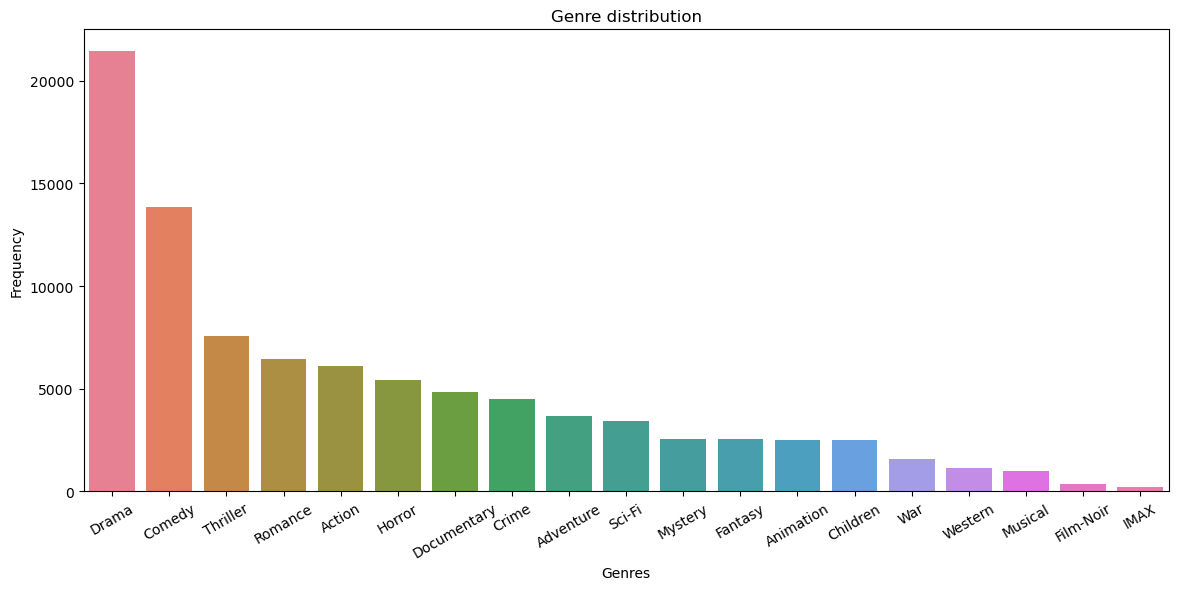

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(x="Genre",y="Count",hue="Genre",data=genre_df)
plt.title("Genre distribution")
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

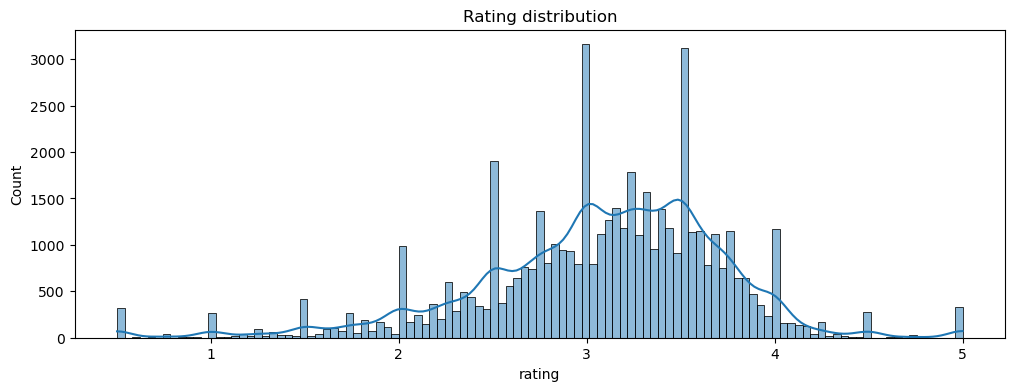

In [43]:
plt.figure(figsize=(12,4))
sns.histplot(data=temp_df,x=temp_df["rating"],kde=True)
plt.title("Rating distribution")
plt.show()

In [ ]:
pos_df=temp_df[temp_df["rating"]>=3] # Assuming rating >=3 are positive reviews
pos_df

,movieId,title,genres,tags,rating,doc_text
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,classic emotional hat fly laughter boost child...,3.89,"title: Toy Story (1995), genres: Adventure Ani..."
1,2,Jumanji (1995),Adventure Children Fantasy,classic store overall fictional trap relations...,3.28,"title: Jumanji (1995), genres: Adventure Child..."
2,3,Grumpier Old Men (1995),Comedy Romance,duringcreditsstinger sequel friend fishing lem...,3.17,"title: Grumpier Old Men (1995), genres: Comedy..."
4,5,Father of the Bride Part II (1995),Comedy,regret sequel martin pregnancy martin duress r...,3.08,"title: Father of the Bride Part II (1995), gen..."
5,6,Heat (1995),Action Crime Thriller,kilmer relationship violent niro job real ange...,3.86,"title: Heat (1995), genres: Action Crime Thril..."
...,...,...,...,...,...,...
50144,288661,Sabotage,(no genres listed),auschwitz resistance sister hang jewish interv...,3.50,"title: Sabotage, genres: (no genres listed),av..."
50146,288679,The Out-Laws (2023),Action Comedy Romance,robbery robber yoga sandler bank see adam humo...,3.11,"title: The Out-Laws (2023), genres: Action Com..."
50148,288731,Esperando a Dalí (2023),Comedy Romance,porn political dalí spain cadaqués relationshi...,3.50,"title: Esperando a Dalí (2023), genres: Comedy..."
50149,288747,LOLA (2023),Drama Sci-Fi,concept white ii black interest nazi world,3.25,"title: LOLA (2023), genres: Drama Sci-Fi,avg. ..."


In [45]:
pos_df["tags"].values

array(['classic emotional hat fly laughter boost child fictional teamwork relationship poster antoinette skateboard sketch rescue tom star touch crane unlikely dvd lipstick rod story binoculars rain buy urban mother control lift villain credit box travel dog brace surgical cartoon played friend party camera rivalry crash hurt debut land animal dimensional catchphrase flat next ohio ventilation recliner lovable original score slide watch talk registry hearted toy yell rival dinosaur buddy hero direction flashback guy bedroom reconnaissance shark mixed art gift biohazard operation leoni ramp best boy confrontation thunderstorm achievement walkie ask see funny time ya card jealousy figure come end disney package shot cgi suburb frustration warm corkboard martial banister famous shaft engage friendship oscar scream depression erlend robot claw fight rescue act point head teapot backyard bull story utah sunroof scheme vhs dachshund soothe lapse plot shut word squeeze product buzz glide fish

In [46]:
positive_tags=pos_df["tags"].values.tolist()

In [47]:
len(positive_tags)

31841

In [48]:
common_words=["director","movie"]

In [49]:
positive_tags=[word for word in positive_tags if word not in common_words]

In [50]:
positive_tags=" ".join(positive_tags)

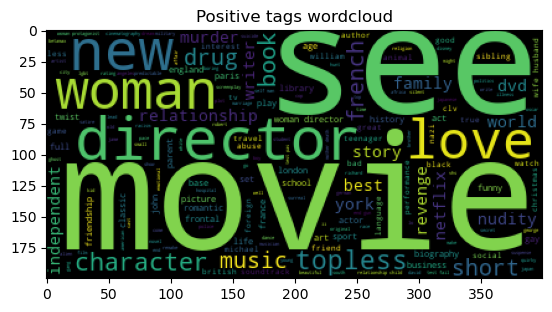

In [ ]:
pos_wc=WordCloud(max_words=1000,background_color="black").generate(positive_tags) # Wordcloud to see dominant words
plt.title("Positive tags wordcloud")
plt.imshow(pos_wc)

In [ ]:
neg_df=temp_df[temp_df["rating"]<3] # Assuming rating <3 are bad reviews
neg_df

,movieId,title,genres,tags,rating,doc_text
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick girl movie single novel base relationshi...,2.87,"title: Waiting to Exhale (1995), genres: Comed..."
11,12,Dracula: Dead and Loving It (1995),Comedy Horror,word dr roll slip splatter enter sequence shap...,2.68,"title: Dracula: Dead and Loving It (1995), gen..."
14,15,Cutthroat Island (1995),Action Adventure Romance,combat scalp relationship modine female heroin...,2.73,"title: Cutthroat Island (1995), genres: Action..."
18,19,Ace Ventura: When Nature Calls (1995),Comedy,classic astral emotional goofy consul raccoon ...,2.67,"title: Ace Ventura: When Nature Calls (1995), ..."
19,20,Money Train (1995),Action Comedy Crime Drama Thriller,bartender word victim combat stakeout train bo...,2.89,"title: Money Train (1995), genres: Action Come..."
...,...,...,...,...,...,...
50145,288667,Black Metal Veins (2012),Documentary,use needle drug dark heroin tragic addict,2.50,"title: Black Metal Veins (2012), genres: Docum..."
50147,288683,A Corsican Summer (2022),Drama,ataraxia pace corsica slow boredom summer village,1.50,"title: A Corsican Summer (2022), genres: Drama..."
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,web deep,1.71,"title: The Deep Web: Murdershow (2023), genres..."
50151,288765,Bird Box Barcelona (2023),Horror Thriller,tw apocalypse survival hole suicide bad plot s...,2.47,"title: Bird Box Barcelona (2023), genres: Horr..."


In [53]:
negative_tags=neg_df["tags"].values.tolist()
negative_tags=" ".join(negative_tags)

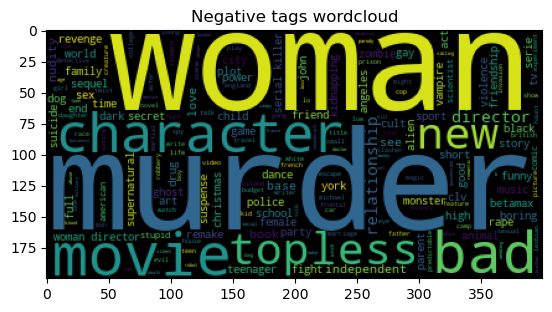

In [55]:
neg_wc=WordCloud(max_words=1000,background_color="black").generate(negative_tags)
plt.title("Negative tags wordcloud")
plt.imshow(neg_wc)

In [57]:
df["doc_text"][0]

'title: Toy Story (1995), genres: Adventure Animation Children Comedy Fantasy,avg. rating: 3.89,tags: classic emotional hat fly laughter boost child fictional teamwork relationship poster antoinette skateboard sketch rescue tom star touch crane unlikely dvd lipstick rod story binoculars rain buy urban mother control lift villain credit box travel dog brace surgical cartoon played friend party camera rivalry crash hurt debut land animal dimensional catchphrase flat next ohio ventilation recliner lovable original score slide watch talk registry hearted toy yell rival dinosaur buddy hero direction flashback guy bedroom reconnaissance shark mixed art gift biohazard operation leoni ramp best boy confrontation thunderstorm achievement walkie ask see funny time ya card jealousy figure come end disney package shot cgi suburb frustration warm corkboard martial banister famous shaft engage friendship oscar scream depression erlend robot claw fight rescue act point head teapot backyard bull story

In [58]:
all_docs=df["doc_text"].values

In [ ]:
# df.to_csv('processed_movie_data.csv') # saving the final dataframe into csv file

# Model Building

In [ ]:
from sentence_transformers import SentenceTransformer
model=SentenceTransformer("all-MiniLM-L6-v2")

embeddings=model.encode(df["doc_text"],convert_to_numpy=True) # Vectorization of text data
embeddings

/home/abhi/miniforge3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-08 17:36:14.830820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-08 17:36:14.866642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-08 17:36:14.878023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-08 17:36:14.993385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

array([[-0.09509214, -0.03056772,  0.09151525, ...,  0.00557359,
        -0.02867701, -0.0019556 ],
       [-0.0302202 ,  0.06977382,  0.04775203, ..., -0.04335079,
        -0.08573309, -0.05752645],
       [-0.10584378, -0.04099359,  0.00033055, ...,  0.01278849,
         0.01778543, -0.00082236],
       ...,
       [ 0.02435467,  0.02121227, -0.00901246, ...,  0.03004266,
         0.0022549 ,  0.00394836],
       [ 0.01414051, -0.08646115,  0.00092582, ...,  0.03347745,
         0.09272789, -0.01206736],
       [ 0.01078634, -0.05614818, -0.00371155, ...,  0.02545559,
        -0.04046089, -0.01201272]], dtype=float32)

In [61]:
embeddings.shape

(50154, 384)

In [ ]:
index=faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [ ]:
# faiss.write_index(index,"final_movie_index.faiss")    # saving the index

In [ ]:
q="good scifi"  # sample test case

q_v=model.encode(q)

In [65]:
dist,ind=index.search(q_v.reshape(1,-1),k=10)

In [66]:
ind[0]

array([40267, 46262, 47781, 33442, 25820, 15052, 44839, 49170, 29011,
       36889])

In [67]:
for x in ind[0]:
    print(all_docs[x])

title: Alistair1918 (2016), genres: Sci-Fi,avg. rating: 2.67,tags: independent
title: Sync (2014), genres: Action Sci-Fi,avg. rating: 4.17,tags: scifi
title: Cosmic Sin (2021), genres: Action Sci-Fi,avg. rating: 1.6,tags: act bad plot science
title: Sunspring (2016), genres: Sci-Fi,avg. rating: 1.8,tags: experimental nonsense
title: Off World (2013), genres: Sci-Fi,avg. rating: 2.25,tags: 
title: Scientist, The (2010), genres: Drama,avg. rating: 2.71,tags: philosophy physic
title: The Beginning and End of the Universe (2016), genres: Documentary,avg. rating: 3.75,tags: physic history astronomy science
title: Infinity 7 (2019), genres: Sci-Fi,avg. rating: 2.5,tags: short
title: 11:00 AM (2013), genres: Fantasy Sci-Fi,avg. rating: 2.27,tags: edit act travel futuristic time good well
title: Realive (2016), genres: Sci-Fi,avg. rating: 3.07,tags: experiment woman boring depression hunk unoriginal pretentious cancer future fear death pretty cryogenics weak suicide plot philosophical


In [68]:
from groq import Groq
import all_api

client=Groq(api_key=all_api.groq_api)

## Recommendation Engine

In [73]:
def recommend_movies(user_text):
    user_vector=model.encode(user_text)
    dis,ind=index.search(user_vector.reshape(1,-1),k=10)
    retirved_chunks=[]
    for x in ind[0]:
        retirved_chunks.append(all_docs[x])
    full_string=" ".join(retirved_chunks)

    completion = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages = [
    {
        "role": "system",
        "content": (
            "You are a movie recommendation assistant. "
            "You must only use the information provided in the retrieved context. "
            "Do not generate or hallucinate new titles. "
            "If the context does not contain enough information, respond with: "
            "'No relevant recommendations found in the database.'"
            " Arrange in decending order of given ratings"
        )
    },
    {
        "role": "user",
        "content": f"Movie metadata: {full_string}\n"
                   f"Based only on the retrieved context, list recommended movies for {user_text}."
    }],
    temperature=0.4,
    max_completion_tokens=1024,
    top_p=1,
    stop=None
    )

    results=completion.choices[0].message.content
    print(results)


In [74]:
recommend_movies(input("Enter keyword,plot,genre"))

Based on the provided metadata, here are the top recommended Sci-Fi movies in descending order of their average ratings:

1. Sync (2014) - avg. rating: 4.17
2. TechnoCalyps (2006) - avg. rating: 3.5
3. Alive in Joburg (2005) - avg. rating: 3.32
4. Pandorica (2016) - avg. rating: 3.0
5. Realive (2016) - avg. rating: 3.07
6. Def-Con 4 (1985) - avg. rating: 2.26
7. Off World (2013) - avg. rating: 2.25
8. Zone 39 (1997) - avg. rating: 2.45
9. Alistair1918 (2016) - avg. rating: 2.67
10. Sunspring (2016) - avg. rating: 1.8
